In [1]:
import os
import glob
from typing import Tuple, List, Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

# bookmaker -- An NBA Deep Learning Prediction Model

## Problem Formulation & Motivation

In May of 2018, the U.S. Supreme Court ruled that individual states had the right to legalize sports betting, overturning a longstanding law. Since then, dozens of states have introduced legislation to allow betting sites to operate within their borders, and the cumulative value of the American sports betting market is expected to reach \$8 billion by 2025.

Anecdotally, betting lines are remarkably accurate at predicting outcomes, but as an aggregation of human opinions, they are inherently biased. We believe that we can improve on these group-think predictions by taking a data-driven approach towards odds making. Traditional NBA forecast models use team-based statistics to predict the outcome of games. Here, we've designed a deep learning system that utilizes individualized player data in addition to conventional game statistics to generate more accurate forecasts of team point production in a given match-up.

## Data Sources & Pre-Processing

Constructing the input features of our model required significant pre-processing of our raw data. The raw data was sourced from three primary stores,

1. `NBA.com`
2. `FiveThirtyEight.com`
3. `sportsbookreviewsonline.com`

and covered the years 2015-2020. We scraped raw box score data from `NBA.com` on a per-game basis by a pre-processing script. From `FiveThirtyEight`, we pulled their proprietary RAPTOR data. The `sportsbookreviewsonline` websites hosts Excel files of historical odds data, which we downloaded directly.

We reserved the 2020 season as a `test` year, 2019 as a `validation` year, and the remainder as `train` years.

In [2]:
example_file = os.path.join('data', 'raw', '2015-nba-boxscores.csv')
boxscore_data = pd.read_csv(example_file, index_col=0)
boxscore_data.sample(5)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
18060,21400520,1610612756,PHX,Phoenix,202738,Isaiah Thomas,NaN,NaN,31:18,5.0,...,1.0,3.0,4.0,1.0,0.0,0.0,2.0,2.0,19.0,14.0
9305,21400864,1610612763,MEM,Memphis,2216,Zach Randolph,F,NaN,36:09,10.0,...,2.0,8.0,10.0,1.0,1.0,0.0,2.0,2.0,20.0,-22.0
22952,21400328,1610612757,POR,Portland,2748,Dorell Wright,NaN,DNP - Coach's Decision,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25762,21400218,1610612750,MIN,Minnesota,203498,Shabazz Muhammad,NaN,NaN,16:02,5.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0,-7.0
8483,21400898,1610612762,UTA,Utah,203504,Trey Burke,NaN,NaN,31:44,7.0,...,1.0,5.0,6.0,8.0,0.0,0.0,2.0,1.0,16.0,5.0


In [3]:
example_file = os.path.join('data', 'raw', 'odds-2014-15.xlsx')
odds_data = pd.read_excel(example_file)
odds_data.head(10)

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
0,1028,501,V,Dallas,24,29,20,27,100,206.5,203.5,140,102
1,1028,502,H,SanAntonio,26,19,31,25,101,6,3.5,-165,4
2,1028,503,V,Orlando,25,16,23,20,84,196,191,380,94.5
3,1028,504,H,NewOrleans,24,24,30,23,101,9.5,9,-475,3.5
4,1028,505,V,Houston,31,31,23,23,108,6.5,7,-300,103
5,1028,506,H,LALakers,19,26,24,21,90,209,207,250,1.5
6,1029,701,V,Milwaukee,24,33,26,17,106,192,193,315,97
7,1029,702,H,Charlotte,25,21,22,32,108,9,8,-390,7.5
8,1029,703,V,Philadelphia,24,27,19,21,91,194,189.5,290,95
9,1029,704,H,Indiana,26,22,30,25,103,8.5,7.5,-350,6


Historical player statistics are typically calculated on a per-season basis. One could use a player's prior season statistics, but this quickly become stale and fail to capture improvements player's make throughout a season. To remedy this, we manually computed "live" statistics. In our pre-processing, we essentially constructed a massive hash table where you could look up current statistics for any date/player pair.

Additionally, the raw odds data was very unstructed and required significant cleaning.

## Model Features and Architecture

We chose to have our model predict the points scored for a single team in a given matchup. One benefit of this decision is that it effectively doubles our training data, since each game results in two observations. Additionally, it gives us some flexibility in evaluating our model. With a predicted score for each team, we can form predictions of both the `spread` and the `over/under`. 

The downside is that our model is not explicitly trained to perfrom well on predicting either the `spread` **or** the `over/under`. 

We limited our analysis to the five starting players, plus a "top" sub defined by minutes played. Doing so could potentially cause a situation where one team's starters have "better" absolute stats simply by playing more minutes. To account for this, we standarized all statistics per 48 minutes. The final features for our model are as follows:
* `this` - (team we are predicting)
    * C1
        * PTS
        * ASTS
        * OREBS
        * FGM
        * FGA
        * FG3M
        * FG3A
        * FTM
        * FTA
    * G1
    * G2
    * F1
    * F2
    * S1
* `other` - (team we are playing against)
    * C1
        * STL
        * DREB
        * BLK
        * TO
    * G1
    * G2
    * F1
    * F2
    * S1
    
For a total of `(6 * 9) + (6 * 4) = 78` total features. All features are Z-score normalized before being piped to the network. This transforms all our features to a comparable scale, and gives us a nice smooth loss curve, as we'll see.

In [4]:
def load_model_data(_type: str) -> Tuple[pd.MultiIndex, torch.tensor, torch.tensor]:
    """
    Retrieve features and score outcomes from the proper data directory so 
    we can feed them into a PyTorch model.
    
    Parameters:
        _type: Choose from {'train', 'dev', 'test'}
        
    Returns:
        A 3-tuple consisting of
            1) A pd.MultiIndex so we can associate the outcomes predicted
            by our model to a particular gameid/teamid
            
            2) A 2D torch.tensor of player/team features normalized by column
            
            3) A 1D torch.tensor that represents the points scored by a team
            in a particular game.
    """
    if _type not in {'train', 'dev', 'test'}:
        msg = f"{_type} not supported. Try 'train', 'dev', or 'test'."
        raise RuntimeError(msg)
    
    df = pd.DataFrame()
    data_path = os.path.join('data', _type, '*-data.csv')
    for fp in glob.glob(data_path):
        season = pd.read_csv(fp)
        # Convert string tuples to actual tuples
        season = season.rename(columns=lambda x: eval(x))
        season = season.set_index([('GAME_ID', '', ''), ('TEAM_ID', '', '')])
        df = df.append(season)
    
    outcome_col = ('TEAM_PTS', '', '')
    features = df[df.columns.difference([outcome_col])]
    # Normalize features
    features = (features - features.mean()) / features.std()
    # Need to keep this a DataFrame so our dimensions work in PyTorch
    scores = df[[outcome_col]]
    
    n_features = len(features.columns)
    n_output = len(scores.columns)
    msg = 'Uh oh, you might be losing features!'
    assert n_features + n_output == len(df.columns), msg
    
    features = torch.from_numpy(features.to_numpy(dtype='float32'))
    scores = torch.from_numpy(scores.to_numpy(dtype='float32'))
    
    simple_index = df.index.rename(['GAME_ID', 'TEAM_ID'])
    return simple_index, features, scores

In [5]:
def load_odds_data(_type: str) -> pd.DataFrame:
    """
    Load the odds DataFrame for a certain domain.
    
    Parameters:
        _type: Choose from 'train', 'dev', or 'test'
        
    Returns:
        A pd.DataFrame indexed by (GAME_ID, TEAM_ID)
    """
    if _type not in {'train', 'dev', 'test'}:
        msg = f"{_type} not supported. Try 'train', 'dev', or 'test'."
        raise RuntimeError(msg)
        
    df = pd.DataFrame()
    data_path = os.path.join('data', _type, '*-odds.csv')
    for fp in glob.glob(data_path):
        season_df = pd.read_csv(fp, index_col=[0, 1])
        df = df.append(season_df)
        
    df = df.reset_index()
    df = df.set_index(['GAME_ID', 'TEAM_ID'])
    return df

In [6]:
def log_two_layers(n: int) -> List[Union[nn.Linear, nn.ReLU]]:
    """
    Given an input with n features, construct a series
    of neural network layers that decrease logarithmically.
    """
    shift_bit_length = lambda x: 1 << (x - 1).bit_length() - 1
    
    layers = []
    while n > 4:
        power_of_two = shift_bit_length(n)
        # nn.Linear uses Xavier initialization
        layers.append( nn.Linear(n, power_of_two) )
        layers.append( nn.ReLU() )
        n = power_of_two
    # Now n == 4 and we add a final regression layer
    layers.append( nn.Linear(n, 1) )
    return layers

Due to the relative scarcity of data, our training time is quick, allowing us to experiment with deeper networks. We employ a novel "log two" neural network that has approximately `log_2(n)` layers, where `n` is the number of features.

Throughout the course of an NBA season, you'll have several 50 and 60 points performances, which even the most astute model would have trouble predicting. In this context, `L1` loss is a more appropriate measure as it does not penalize outliers as severely.

## Model Training

In [7]:
# Roughly follows https://pytorch.org/tutorials/beginner/nn_tutorial.html#

# Model hyperparameters
num_epochs = 500
batch_size = 100
learning_rate = 0.0001

# Load data as torch.tensors
_, x_train, y_train = load_model_data('train')
_, x_validate, y_validate = load_model_data('dev')

# Define our model layers by decreasing powers of two
model = nn.Sequential( *log_two_layers(x_train.shape[1]) )
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_ds = TensorDataset(x_train, y_train)
# Notice we shuffle our training data so the seasons are mixed!
train_dl = DataLoader(train_ds, batch_size=batch_size, 
                      shuffle=True)

validate_ds = TensorDataset(x_validate, y_validate)
validate_dl = DataLoader(validate_ds, 
                         batch_size=batch_size * 2)

# L1 loss is more robust to outliers
loss_func = F.smooth_l1_loss

losses = []
for epoch in range(num_epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        epoch_loss = sum(loss_func(model(xb), yb) for xb, yb in validate_dl)
        losses.append( epoch_loss / len(xb) )

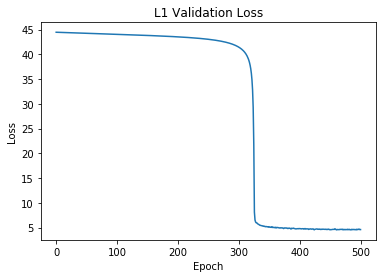

In [8]:
plt.title('L1 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

## Model Evaluation

In [9]:
def score(
        model: nn.Sequential, 
        bet: str, 
        category: str,
        buffer: float=1.
) -> Tuple[int, int, int]:
    """
    This function handles some preliminary data loading tasks before redirecting to 
    the more specific _score_spread() and _score_overunder() functions.
    
    Parameters:
        model: The ANN object with learned parameters
        bet: Either 'spread' or 'over/under'
        category: Either 'open' or 'close'
        buffer: How much our model must contradict the odds to place a bet.
                Otherwise we just 'push' and don't take any action.
        
    Returns:
        A three-tuple consisting of (bets won, bets lost, bets pushed)
    """
    if buffer < 0:
        raise RuntimeError(f'{buffer=} makes no sense')
        
    if category not in {'open', 'close'}:
        raise RuntimeError(f"{category=} not valid, must be in ['open', 'close']")
    
    i_test, x_test, y_test = load_model_data('test')
    y_predicted = model(x_test)
    
    # pd.Series are way easier to handle than tensors
    y_hat = pd.Series(y_predicted.detach().squeeze(), index=i_test)
    y = pd.Series(y_test.detach().squeeze(), index=i_test)

    odds = load_odds_data('test').dropna()
    intersection = odds.index.intersection(i_test)

    # Drop some games, since our prepared NBA data doesn't contain
    # every game in the season.
    odds = odds.loc[intersection]
    y_hat = y_hat.loc[intersection]
    y = y.loc[intersection]
    
    # Check that both data sources agree on the points scored
    assert (y == odds['pts']).all()

    if bet == 'over/under':
        return _score_overunder(model, odds[f'ou_{category}'], 
                                y, y_hat, buffer)
    
    elif bet == 'spread':
        return _score_spread(model, odds[f'spread_{category}'], 
                             y, y_hat, buffer)
        
    else:
        msg = f"{bet=} not valid, must be in ['over/under', 'spread']"
        raise RuntimeError(msg)

In [10]:
def _score_spread(
        model: nn.Sequential, 
        odds: pd.Series, 
        y: pd.Series, 
        y_hat: pd.Series,
        buffer: float=1.
) -> Tuple[int, int, int]:
    """
    Given a 'buffer', determine how many 'spread' bets we would have
    placed and won.
    
    Parameters:
        model: ANN with trained model parameters
        odds: A slice of the original df with either 'open' or 'close'
        y: Actual score outcomes per team
        y_hat: Predicted score outcomes per team
        buffer: A measure of how much our model must contradict the odds
                in order to place a bet.
                
    Returns:
        A three-tuple consisting of (games won, games lost, no action taken)
    """
    # We need to divided be -2 here because the favorite is always given a negative
    # spread, but we actually want a positive difference with the opponent
    bookie = odds.groupby(level='GAME_ID').diff().dropna() / -2
    actual_spreads = y.groupby(level='GAME_ID').diff().dropna()
    model_spreads = y_hat.groupby(level='GAME_ID').diff().dropna()
    
    long = model_spreads - buffer > bookie
    won_long = long & (actual_spreads > bookie)
    
    short = model_spreads + buffer < bookie
    won_short = short & (actual_spreads < bookie)
    
    push = ~long & ~short
    
    won = won_long.sum() + won_short.sum()
    lost = long.sum() + short.sum() - won
    pushed = push.sum()
    
    return won, lost, pushed

In [11]:
def _score_overunder(
        model: nn.Sequential, 
        odds: pd.Series, 
        y: pd.Series, 
        y_hat: pd.Series,
        buffer: float=1.
) -> Tuple[int, int, int]:
    """
    Given a 'buffer', determine how many over/under bets we would have
    placed and won.
    
    Parameters:
        model: ANN with trained model parameters
        odds: A slice of the original df with either 'open' or 'close'
        y: Actual score outcomes per team
        y_hat: Predicted score outcomes per team
        buffer: A measure of how much our model must contradict the odds
                in order to place a bet.
                
    Returns:
        A three-tuple consisting of (games won, games lost, no action taken)
    """
    bookie = odds.groupby(level='GAME_ID').first()
    actual_totals = y.groupby(level='GAME_ID').sum()
    model_totals = y_hat.groupby(level='GAME_ID').sum()
    
    long = model_totals + buffer < bookie
    won_long = long & (actual_totals < bookie)
    
    short = model_totals - buffer > bookie
    won_short = short & (actual_totals > bookie)
    
    push = ~long & ~short
    
    won = won_long.sum() + won_short.sum()
    lost = long.sum() + short.sum() - won
    pushed = push.sum()
    
    return won, lost, pushed

In [12]:
# OVER/UNDER results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 50, 2):
    won, lost, pushed = score(model, 'over/under', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 462  534    0 0.464 0.000
	 2 445  513   38 0.465 0.038
	 4 423  489   84 0.464 0.084
	 6 395  449  152 0.468 0.153
	 8 379  419  198 0.475 0.199
	10 336  386  274 0.465 0.275
	12 307  337  352 0.477 0.353
	14 269  293  434 0.479 0.436
	16 222  244  530 0.476 0.532
	18 186  198  612 0.484 0.614
	20 155  159  682 0.494 0.685
	22 126  119  751 0.514 0.754
	24 101   90  805 0.529 0.808
	26  78   66  852 0.542 0.855
	28  53   45  898 0.541 0.902
	30  35   33  928 0.515 0.932
	32  26   16  954 0.619 0.958
	34  20    9  967 0.690 0.971
	36  12    3  981 0.800 0.985
	38   8    3  985 0.727 0.989
	40   6    3  987 0.667 0.991
	42   3    1  992 0.750 0.996
	44   2    1  993 0.667 0.997
	46   1    0  995 1.000 0.999
	48   1    0  995 1.000 0.999


In [13]:
# OVER/UNDER results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print('\t' + '-' * len(header))
for b in range(0, 50, 2):
    won, lost, pushed = score(model, 'over/under', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 473  523    0 0.475 0.000
	 2 457  502   37 0.477 0.037
	 4 431  477   88 0.475 0.088
	 6 402  452  142 0.471 0.143
	 8 382  414  200 0.480 0.201
	10 342  371  283 0.480 0.284
	12 310  332  354 0.483 0.355
	14 278  285  433 0.494 0.435
	16 233  234  529 0.499 0.531
	18 197  191  608 0.508 0.610
	20 162  150  684 0.519 0.687
	22 133  125  738 0.516 0.741
	24 105   85  806 0.553 0.809
	26  79   59  858 0.572 0.861
	28  57   44  895 0.564 0.899
	30  41   27  928 0.603 0.932
	32  33   17  946 0.660 0.950
	34  25    7  964 0.781 0.968
	36  17    3  976 0.850 0.980
	38   8    2  986 0.800 0.990
	40   7    2  987 0.778 0.991
	42   7    1  988 0.875 0.992
	44   6    0  990 1.000 0.994
	46   4    0  992 1.000 0.996
	48   4    0  992 1.000 0.996


In [14]:
# SPREAD results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 30, 2):
    won, lost, pushed = score(model, 'spread', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 472  524    0 0.474 0.000
	 2 371  409  216 0.476 0.217
	 4 279  295  422 0.486 0.424
	 6 203  208  585 0.494 0.587
	 8 132  144  720 0.478 0.723
	10  76   91  829 0.455 0.832
	12  48   51  897 0.485 0.901
	14  24   23  949 0.511 0.953
	16  13   12  971 0.520 0.975
	18   7    5  984 0.583 0.988
	20   4    3  989 0.571 0.993
	22   1    2  993 0.333 0.997
	24   1    0  995 1.000 0.999
	26   1    0  995 1.000 0.999
	28   0    0  996 0.000 1.000


In [15]:
# SPREAD results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 30, 2):
    won, lost, pushed = score(model, 'spread', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 478  518    0 0.480 0.000
	 2 384  398  214 0.491 0.215
	 4 281  295  420 0.488 0.422
	 6 211  201  584 0.512 0.586
	 8 135  141  720 0.489 0.723
	10  87   88  821 0.497 0.824
	12  54   41  901 0.568 0.905
	14  31   20  945 0.608 0.949
	16  13    8  975 0.619 0.979
	18   7    6  983 0.538 0.987
	20   3    2  991 0.600 0.995
	22   3    0  993 1.000 0.997
	24   3    0  993 1.000 0.997
	26   3    0  993 1.000 0.997
	28   2    0  994 1.000 0.998


## Open Questions

* Would directly predicting `spread` or `over/under` work better?
* Can attention layers help learn the interactions of different players on the court
* What other features would prove helpful?